# Collaboration and Competition

---

In this notebook, we use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 0. Get Prepared
Follow these instructions if you are working locally (you want to setup a Jupyter Notebook locally).
 Otherwise skip to Section 1.

#### 0.1 Setup the right Python version
Use Python 3.6. You may want to either use a virtual env or setup a Conda environment as explained [here](https://github.com/udacity/deep-reinforcement-learning#dependencies)

#### 0.2 Get the python dependencies requirements.txt
Checkout the ./python folder of the Udacity DRLND repo:

https://github.com/udacity/deep-reinforcement-learning

It has a requirements.txt to ensure installing the necessary dependencies in the version specified by the course
(do this only when you want to work locally). Otherwise use the reference notebook provided by the course which is pre setup properly.

#### 0.3 Get the Pre-built Unity Environment
Since this is an RL problem an environment is needed.
The course requires you to use the pre-built environment.
Get the right version for you from the link provided in Tennis_Linux_No_Vis/README

#### 0.4 Install Dependencies

Run the next code cell to install a few packages.  This line will take a few minutes to run!

Make sure you have the python folder with the right requirements.txt. See Section 0.

In [ ]:
import os
deps_dir="./"
deps_file=os.path.join(deps_dir,"requirements.txt")
if os.path.exists(deps_file):
    !pip -q install -r $deps_file
else:
    print("Could not locate requirements.txt. Check section 0")

### 1. Explore the Environment
<span style="color:red">WARNING: DON'T EXECUTE THIS CELL IF YOU WILL ACTUALLY USE THE ENV FOR TRAINING BELOW. The provided unity env is buggy and training simply fails. You would need to restart the Kernel.</span>.

In the following you get the chance to load the environment to:

In the next code cells, you will learn how to use the Python API to control the agent and receive feedback from the environment.

- make sure you can load it at all
- explore its characteristics

#### 1.1 Explore Characteristcs

In [ ]:
from unityagents import UnityEnvironment
import numpy as np

# select this option to load version 1 (with a single agent) of the environment
# env = UnityEnvironment(file_name='Reacher_One_Linux_NoVis/Reacher.x86_64')

# select this option to load version 2 (with 20 agents) of the environment
env = UnityEnvironment(file_name='Tennis_Linux_NoVis/Tennis.x86_64')

In [ ]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

#### 1.2 Take Random Actions in the Environment

Note that **in this coding environment, you will not be able to watch the agent while it is training**, and you should set `train_mode=True` to restart the environment.

In [ ]:
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

When finished, you can close the environment.

In [ ]:
env.close()

### 2. Training an MADDPG Agent to Solve the Challenge

As you can see above a purely random agent performs - as expected - very poorly.
Let's train a clever agent that can susbstantially outperform it.
Important notes:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine!

/home/q409893/work/tools/miniconda3/envs/udacity/lib/python3.6/site-packages/torch/nn/functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/q409893/work/repos/udacity/collaboration_and_competition_project/ReplayBuffer.py:46: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  self.device) for i in range(self.num_collaborating_agents)]
/home/q409893/work/repos/udacity/collaboration_and_competition_project/ReplayBuffer.py:49: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  self.device) for i in range(self.num_collaborating_agents)]
/home/q409893/work/repos/udacity/collaboration_and_competition_project/ReplayBuffer.py:52: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in

Episode 20	Average max agent Score: 0.03. Average duration 0.0s. Avg timestep reached 20.0
Episode 40	Average max agent Score: 0.02. Average duration 0.2s. Avg timestep reached 16.8
Episode 60	Average max agent Score: 0.00. Average duration 0.1s. Avg timestep reached 13.2
Episode 80	Average max agent Score: 0.00. Average duration 0.2s. Avg timestep reached 13.2
Noise variance: 0.6057704364907279de score: 0.00. Duration: 0.1s
Episode 100	Average max agent Score: 0.00. Average duration 0.2s. Avg timestep reached 13.2
Episode 120	Average max agent Score: 0.00. Average duration 0.1s. Avg timestep reached 13.2
Episode 140	Average max agent Score: 0.00. Average duration 0.1s. Avg timestep reached 13.2
Episode 160	Average max agent Score: 0.00. Average duration 0.2s. Avg timestep reached 13.2
Episode 180	Average max agent Score: 0.00. Average duration 0.1s. Avg timestep reached 13.2
Noise variance: 0.36695782172616703al score: 0.00. Duration: 0.1s
Episode 200	Average max agent Score: 0.00. Av

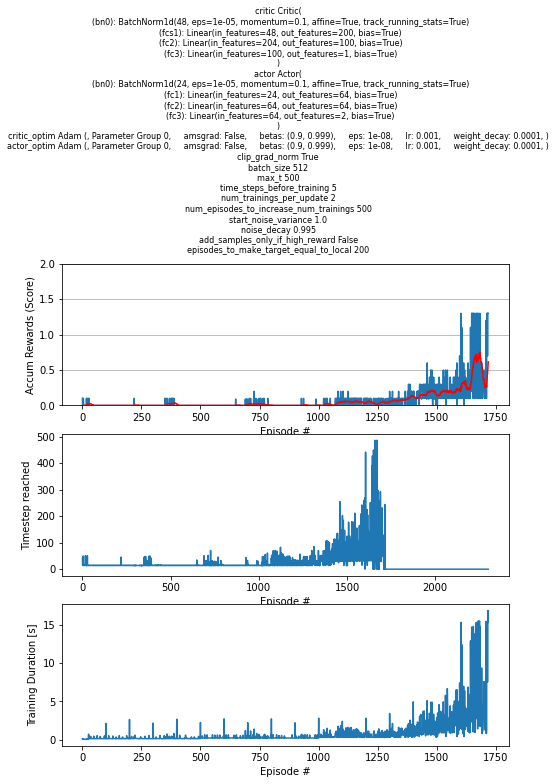

In [2]:
from collaboration_and_competition_project.ReplayBuffer import ReplayBuffer
from collaboration_and_competition_project.helpers import generate_training_plots

BUFFER_SIZE = int(1e5)  # replay buffer size # TODO: check value

from collaboration_and_competition_project import state_size, action_size, num_agents, device
from collaboration_and_competition_project.agent import Agent
from collaboration_and_competition_project.maddpg import run_maddpg

batch_size = 512

replay_buffer = ReplayBuffer(action_size=action_size,
                             buffer_size=BUFFER_SIZE,
                             batch_size=batch_size,
                             random_seed=2,
                             num_collaborating_agents=num_agents,
                             device=device)

agent = Agent(device=device,
              state_size=state_size, action_size=action_size, random_seed=2, num_competing_agents=num_agents,
              num_trainings_per_update=2,
              time_steps_before_training=5,
              batch_size=batch_size,
              num_episodes_to_increase_num_trainings=500,
              lr_actor=1e-3,
              lr_critic=1e-3,
              clip_grad_norm=True,
              weight_decay= 0.0001,
              start_noise_variance = 1.0,
              replay_buffer=replay_buffer,
              add_samples_only_if_high_reward=False,
              debug=False)

episodes_to_make_target_equal_to_local = 200
max_timesteps_per_episode = 500

scores_global, episode_durations, episode_timestep_reached = run_maddpg(agent=agent,
                                        n_episodes=2300,
                                        max_t=max_timesteps_per_episode,
                                        print_every=20,
                                        episodes_to_make_target_equal_to_local=episodes_to_make_target_equal_to_local)

details_dict = {"critic": agent.critics_local[0].__repr__(),
                 "actor": agent.actors_local[0].__repr__(),
                 "critic_optim": agent.critic_optimizers[0].__repr__().replace("\n", ", "),
                 "actor_optim": agent.actor_optimizers[0].__repr__().replace("\n", ", "),
                 "clip_grad_norm": agent.clip_grad_norm,
                 "batch_size": agent.batch_size,
                 "max_t": max_timesteps_per_episode,
                 "time_steps_before_training": agent.time_steps_before_training,
                 "num_trainings_per_update": agent.num_trainings_per_update,
                 "num_episodes_to_increase_num_trainings": agent.num_episodes_to_increase_num_trainings,
                 "start_noise_variance": agent.start_noise_variance,
                 "noise_decay": agent.noise_decay,
                 "add_samples_only_if_high_reward": agent.add_samples_only_if_high_reward,
                 "episodes_to_make_target_equal_to_local": episodes_to_make_target_equal_to_local
                 }
generate_training_plots(scores_global, episode_durations, episode_timestep_reached,
                        details_dict)



